# Noise Estimation and Adaptive Encoding for Asymmetric Quantum Error Correcting Codes
_Jan Florjanczyk, Supervisor: Todd A. Brun_



In [1]:
% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("whitegrid")
from drift_qec.oneangledephasing import *

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


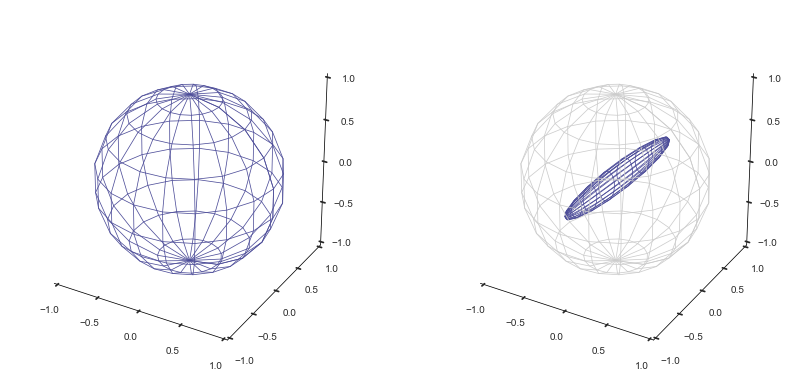

In [43]:
fig = plt.figure(figsize=(14,10))
axs = ["", ""]
axs[0] = fig.add_subplot(121, projection='3d')
axs[1] = fig.add_subplot(122, projection='3d')

axs[0].set_aspect("equal")
axs[0].set_frame_on(False)
axs[0].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[0].grid(False)

axs[1].set_aspect("equal")
axs[1].set_frame_on(False)
axs[1].w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axs[1].grid(False)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
axs[0].plot_wireframe(x, y, z, color=[0.3, 0.3, 0.6], linewidth=0.75)
axs[1].plot_wireframe(x, y, z, color=[0.8, 0.8, 0.8], linewidth=0.75)
x0=0.2*np.cos(u)*np.sin(v)
y0=0.1*np.sin(u)*np.sin(v)
z0=0.9*np.cos(v)
x1 = x0*np.sin(0.5) + y0*np.cos(0.5)
y1 = x0*np.cos(0.5) - y0*np.sin(0.5)
z1 = z0
x = x1*np.sin(-0.8) + z1*np.cos(-0.8)
y = y1
z = x1*np.cos(-0.8) - z1*np.sin(-0.8)
axs[1].plot_wireframe(x, y, z, color=[0.3, 0.3, 0.6], linewidth=0.75)

## Fixed angle dephasing channel

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


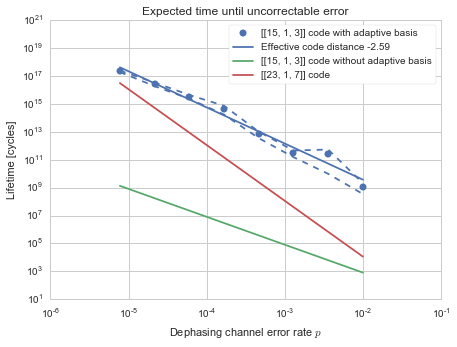

In [44]:
df = pd.read_csv("data/OneAngleDephasingFixed/src.csv", index_col=0)
times = df[["rate", "time"]].groupby(["rate"]).aggregate([np.mean, sp.stats.sem])
times.columns=["mean", "sem"]

x = np.log(times["mean"].index)
y = np.log(times["mean"].values)
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x,y)
f = np.exp(intercept + x * slope)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.loglog(times.index, times["mean"], marker="o", ls="", color=sns.color_palette()[0], label="[[15, 1, 3]] code with adaptive basis")
ax.loglog(times.index, times["mean"] - times["sem"], ls="--", color=sns.color_palette()[0])
ax.loglog(times.index, times["mean"] + times["sem"], ls="--", color=sns.color_palette()[0])
ax.loglog(times.index, f, color=sns.color_palette()[0], ls="-", label="Effective code distance {:1.2f}".format(slope))
ax.loglog(times.index, 16.0/(63.0 * 3.141592 * (times.index.values ** 2)), color=sns.color_palette()[1], label="[[15, 1, 3]] code without adaptive basis")
ax.loglog(times.index, 1.0/(8855.0 * (times.index.values ** 4)), color=sns.color_palette()[2], label="[[23, 1, 7]] code")
ax.axis([1e-6, 1e-1, 1e1, 1e21])
ax.set_title("Expected time until uncorrectable error")
ax.set_xlabel("Dephasing channel error rate $p$")
ax.set_ylabel("Lifetime [cycles]")
ax.legend(frameon=True)
fig.savefig("figures/fixedangledephasinglifetimes.pdf")

## Drifting angle dephasing channel

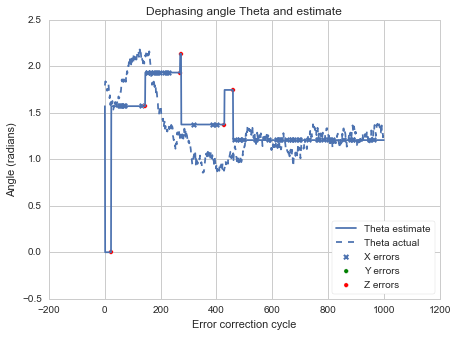

In [42]:
max_time = 1000
params = {"Theta": Theta(max_time, grains=10000, sigma=0.03)}
constants = {"p": Constant(0.003, "p")}

estimator = OneAngleDephasingEstimator(params, constants)
channel = OneAngleDephasingChannel(15, max_time)
report = Report("One Angle Dephasing")

time = 0
while time < max_time:
    s = channel.error(estimator.params, estimator.constants, time)
    estimator.update(s, time)
    report.record(s, time)
    time = time + 1
report.exit(time, "oot", estimator)

fig, ax = plt.subplots(figsize=(7, 5))
report.plot(ax, weightson=True)
ax.legend(frameon=True, loc=4)
ax.set_title("Dephasing angle Theta and estimate")
ax.set_ylabel("Angle (radians)")
ax.set_xlabel("Error correction cycle")
fig.savefig("figures/driftingangledephasingrun.pdf")

In [ ]:
df = pd.concat([pd.read_csv(path) for path in glob("data/OneAngleDephasingDrift/*.csv")])
s = df.groupby(["error_rate", " drift_rate"]).aggregate([np.mean, sp.stats.sem])